Lien du dataset : https://www.kaggle.com/code/prabhavsingh/urbansound8k-classification

#Linking collab to drive 

In [1]:
# drive mount 
from google.colab import drive
drive.mount('/content/drive', force_remount=True) 

Mounted at /content/drive


In [2]:
# drive mount 
import os
import sys 

os.chdir('/content/drive/My Drive/POLY/polyIA/Gunshot_detection/Dossier_participant/urbansound8k_dataset')

In [3]:
!ls

assets			fold4		   participant_urbansound8k.csv
example_submission.csv	fold5		   saved_model.pb
fold1			fold6		   submission.csv
fold10			fold7		   train_data.csv
fold11			fold8		   validation_data.csv
fold12			fold9		   variables
fold2			keras_metadata.pb
fold3			model_256


# Librairies

In [4]:
# Basic Libraries

import pandas as pd
import numpy as np

pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import MinMaxScaler

# Libraries for Classification and building Models

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D, Dropout
from tensorflow.keras.utils import to_categorical 

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC


# Librosa librairies

import os
import librosa
import librosa.display
import glob 
import skimage

# Quick view of the data

In [5]:
df_submission = pd.read_csv("../submission_file_baseline.csv")

In [6]:
#observe data
df = pd.read_csv("./participant_urbansound8k.csv")
# train data
df.head()

,slice_file_name,ID,fold,Label
0,100032-3-0-0.wav,100032-3-0-0,5,False
1,100263-2-0-117.wav,100263-2-0-117,5,False
2,100263-2-0-121.wav,100263-2-0-121,5,False
3,100263-2-0-126.wav,100263-2-0-126,5,False
4,100263-2-0-137.wav,100263-2-0-137,5,False


In [7]:
# test data
df["Label"].tail(5)

10380    NaN
10381    NaN
10382    NaN
10383    NaN
10384    NaN
Name: Label, dtype: object

description des colonnes https://www.kaggle.com/code/prabhavsingh/urbansound8k-classification?cellIds=12&kernelSessionId=30301228

# Extracting training data from 'urbansound8k_train_gunshot.csv'

In [8]:
df_train = df.dropna()

In [9]:
df_train[df_train["Label"]==False]

,slice_file_name,ID,fold,Label
0,100032-3-0-0.wav,100032-3-0-0,5,False
1,100263-2-0-117.wav,100263-2-0-117,5,False
2,100263-2-0-121.wav,100263-2-0-121,5,False
3,100263-2-0-126.wav,100263-2-0-126,5,False
4,100263-2-0-137.wav,100263-2-0-137,5,False
...,...,...,...,...
7074,99812-1-2-0.wav,99812-1-2-0,7,False
7075,99812-1-3-0.wav,99812-1-3-0,7,False
7076,99812-1-4-0.wav,99812-1-4-0,7,False
7077,99812-1-5-0.wav,99812-1-5-0,7,False


# Visualization des audios

### avec gunshot

In [10]:
dat1, sampling_rate1 = librosa.load('./fold1/102305-6-0-0.wav')

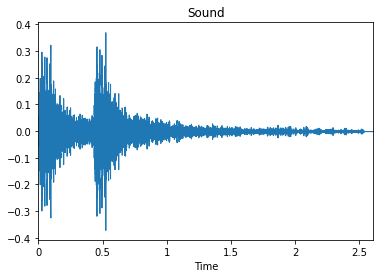

In [11]:
# Prétraitement
import IPython.display as ipd #Allows Audio files to be played directly in the notebook


librosa.display.waveplot(dat1)
plt.title("Sound")
ipd.Audio('./fold1/102305-6-0-0.wav')

Text(0.5, 1.0, 'Linear-frequency power spectrogram')

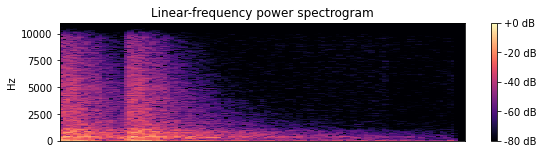

In [12]:
plt.figure(figsize=(20, 10))
D = librosa.amplitude_to_db(np.abs(librosa.stft(dat1)), ref=np.max)
plt.subplot(4, 2, 1)
librosa.display.specshow(D, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')

### sans gunshot

In [13]:
dat2, sampling_rate2 = librosa.load('./fold5/100032-3-0-0.wav')

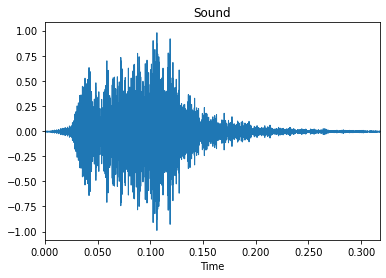

In [14]:
# Prétraitement
import IPython.display as ipd #Allows Audio files to be played directly in the notebook


librosa.display.waveplot(dat2)
plt.title("Sound")
ipd.Audio('./fold5/77247-6-0-0.wav')

Text(0.5, 1.0, 'Linear-frequency power spectrogram')

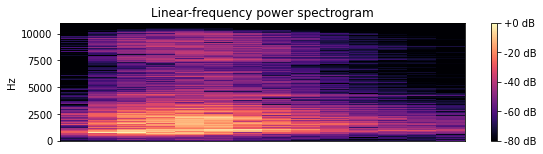

In [15]:
plt.figure(figsize=(20, 10))
D = librosa.amplitude_to_db(np.abs(librosa.stft(dat2)), ref=np.max)
plt.subplot(4, 2, 1)
librosa.display.specshow(D, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')

# Preprocessing (extraction of features)

In [16]:
# sanity check
from os import listdir
from os.path import isfile, join
somme=0
for i in range(1,9):
  somme+= len([f for f in listdir("./fold"+str(i)) if isfile(join("./fold"+str(i), f))])
somme

7079

In [19]:
'''dimension of the features extracted with MFCC features from librosa'''

dat1, sampling_rate1 = librosa.load('./fold1/102305-6-0-0.wav')
arr = librosa.feature.mfcc(y=dat1, sr=sampling_rate1)
arr.shape

(20, 113)

In [20]:
'''dimension of the features extracted with MFCC features from librosa'''
dat1, sampling_rate1 = librosa.load('./fold5/100032-3-0-0.wav')
arr = librosa.feature.mfcc(y=dat1, sr=sampling_rate1)
arr.shape

(20, 14)

You can see that arrays are of different length, it is because the audios are of different length !! 

In [ ]:
from tqdm import tqdm


nb_feat = len(df_train)

def parser(df, first_path = './fold'):
    # Function to load files and extract features
    feature = []
    label = []
    for i in tqdm(df.index):
      # we first load the files one by one
      file_name = first_path + str(df["fold"][i]) + '/' + df["slice_file_name"][i]
      # Here kaiser_fast is a technique used for faster extraction
      X, sampling_rate = librosa.load(file_name, res_type='kaiser_fast') 
      """
      try :
        file_name = first_path + str(df["fold"][i]) + '/' + df["slice_file_name"][i]
        # Here kaiser_fast is a technique used for faster extraction
        X, sampling_rate = librosa.load(file_name, res_type='kaiser_fast') 
      except :
        continue
      """
      # We extract mfcc feature from data. CAREFUL we compute the means of each features. 
      # Good trick for audio of different lenghts
      mels = np.mean(librosa.feature.mfcc(y=X, sr=sampling_rate),axis=1)  

      feature.append(mels)
      if df["Label"][i] == True : 
        label.append(int(0))
      else :
        label.append(int(1))
        

    return [feature, label]

In [ ]:
# Ça prend du temps
temp = parser(df_train,first_path = './fold')

temp = np.array(temp)
data = temp.transpose()

 40%|███▉      | 2830/7079 [14:51<24:25,  2.90it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1323
  n_fft, y.shape[-1]
 95%|█████████▌| 6757/7079 [34:53<01:06,  4.87it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1103
  n_fft, y.shape[-1]
 95%|█████████▌| 6760/7079 [34:54<01:07,  4.76it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1523
  n_fft, y.shape[-1]
100%|██████████| 7079/7079 [36:32<00:00,  3.23it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating t

In [ ]:
X_ = data[:, 0].copy()
Y_ = data[:, 1].copy()
print(X_.shape, Y_.shape)

(7079,) (7079,)


In [ ]:
X = np.ones((len(df_train), len(X_[0])))
Y = np.empty([len(df_train)])

In [ ]:
X.shape

(7079, 20)

In [ ]:
for i in range(len(df_train)):
    Y[i] = int(Y_[i])
    X[i] = (X_[i])

In [ ]:
# finale data shape
print(X.shape)
print(Y.shape)

(7079, 20)
(7079,)


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, 
                                                    test_size=0.33, 
                                                    random_state=42)


# Training and defining model

## SVC

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, f1_score,confusion_matrix, precision_score, recall_score


clf = make_pipeline(
    StandardScaler(),
    SVC(kernel='rbf', class_weight="balanced"),
)
clf.fit(X_train,Y_train)
clf.score(X_test,Y_test)

0.9768934531450578

In [ ]:
Y_test_pred = clf.predict(X_test)

In [ ]:
# print results
print(f'Test f1-score macro : ',f1_score(Y_test, Y_test_pred, average="macro"))
print(f'Test precision-score macro : ',precision_score(Y_test, Y_test_pred, average="macro"))
print(f'Test recall-score macro : ',recall_score(Y_test, Y_test_pred, average="macro"))
print(f'Test roc-score macro : ',roc_auc_score(Y_test, Y_test_pred))
print(f'Test confusion matrix : ',confusion_matrix(Y_test, Y_test_pred))

Test f1-score macro :  0.8785343035343035
Test precision-score macro :  0.831289736603088
Test recall-score macro :  0.9444918352425055
Test roc-score macro :  0.9444918352425055
Test confusion matrix :  [[  90    9]
 [  45 2193]]


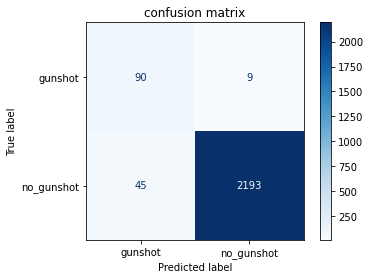

<Figure size 1440x1440 with 0 Axes>

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

labels = ["gunshot","no_gunshot"]

disp = ConfusionMatrixDisplay.from_estimator(
        clf,
        X_test,
        Y_test,
        display_labels=labels,
        cmap=plt.cm.Blues,
        normalize=None,
    )
disp.ax_.set_title("confusion matrix")


plt.figure(figsize=(20,20))

plt.show()

## Logistic Regression

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression


log = make_pipeline(
    StandardScaler(),
    LogisticRegression(),
)
log.fit(X_train,Y_train)
log.score(X_test,Y_test)

0.952931108258451

In [ ]:
Y_test_pred_LR = log.predict(X_test)

In [ ]:
# print results
print(f'Test f1-score macro : ',f1_score(Y_test, Y_test_pred_LR, average="macro"))
print(f'Test precision-score macro : ',precision_score(Y_test, Y_test_pred_LR, average="macro"))
print(f'Test recall-score macro : ',recall_score(Y_test, Y_test_pred_LR, average="macro"))
print(f'Test roc-score macro : ',roc_auc_score(Y_test, Y_test_pred_LR))
print(f'Test confusion matrix : ',confusion_matrix(Y_test, Y_test_pred_LR))

Test f1-score macro :  0.4968724556898604
Test precision-score macro :  0.5173772011121409
Test recall-score macro :  0.502369539903052
Test roc-score macro :  0.502369539903052
Test confusion matrix :  [[   1   98]
 [  12 2226]]


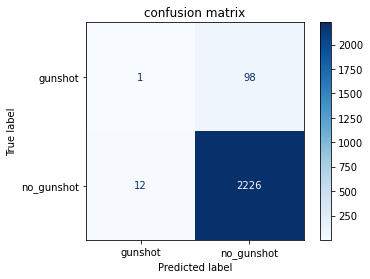

<Figure size 1440x1440 with 0 Axes>

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

labels = ["gunshot","no_gunshot"]

disp = ConfusionMatrixDisplay.from_estimator(
        log,
        X_test,
        Y_test,
        display_labels=labels,
        cmap=plt.cm.Blues,
        normalize=None,
    )
disp.ax_.set_title("confusion matrix")


plt.figure(figsize=(20,20))

plt.show()

# Other cool Ideas and Useful Links

Autre idée des CNNs : https://www.kaggle.com/code/prabhavsingh/urbansound8k-classification/notebook

autre lien utile : https://jovian.ai/charmzshab/urban-sound-dataset

# Creation of the CSV file


In [ ]:
df_test = df[df['Label'].isna()]

In [ ]:
len(df_test.index)

3306

In [ ]:
df_test

,slice_file_name,ID,fold,Label
7079,101729-0-0-1.wav,101729-0-0-1,9,NaN
7080,101729-0-0-11.wav,101729-0-0-11,9,NaN
7081,101729-0-0-12.wav,101729-0-0-12,9,NaN
7082,101729-0-0-13.wav,101729-0-0-13,9,NaN
7083,101729-0-0-14.wav,101729-0-0-14,9,NaN
...,...,...,...,...
10380,312731-4-3-8.wav,312731-4-3-8,12,NaN
10381,388698-9-5-8.wav,388698-9-5-8,12,NaN
10382,360725-1-6-7.wav,360725-1-6-7,12,NaN
10383,392825-0-7-8.wav,392825-0-7-8,12,NaN


In [ ]:
# Ça prend du temps
temp = parser(df_test, first_path = './fold')

temp = np.array(temp)
data = temp.transpose()

100%|██████████| 3306/3306 [03:40<00:00, 15.00it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  after removing the cwd from sys.path.


In [ ]:
data_bis = data.copy()

In [ ]:
X_test_set_ = data_bis[:, 0].copy()
print(X_test_set_.shape)

(3306,)


In [ ]:
X_test_set = np.empty([len(data_bis), len(X_test_set_[0])])

In [ ]:
for i in range(len(data_bis )):
    X_test_set[i] = (X_test_set_[i])

In [ ]:
Y_test_set_pred = clf.predict(X_test_set)

In [ ]:
df_test_out = df_test.copy()

In [ ]:
df_test_out["Label"] = Y_test_set_pred
df_test_out["Label"] = df_test_out["Label"].map({1.0:False, 0.0:True})
df_test_out.to_csv("../submission_file_baseline.csv",index=False)

In [ ]:
df_test_out_k = df_test_out.drop(['slice_file_name', 'fold'], axis=1)

In [ ]:
df_test_out_k.to_csv("../kaggle_submission_file_baseline.csv", index=False)